In [ ]:
# This is the notebook accompanying the band eraser method
# introduced in the paper arXiv: 2405.17400
# This notebook has code snippets from the IAS pipeline
# For any ambiguity or if you need any more info, please contact jayw@ias.edu

In [ ]:
# We will use the band eraser to make plots shown in the left-panel of Fig.4 
# for cleaning the residual lines in the tgps file 1240793088

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This is the main function for the band eraser and is used below
def band_eraser(
        strain, strain_wt, dt, notch_pars=None, hole_mask=None):
    """
    Detects bandlimited excess power transients and removes them
    :param strain: Raw strain data, modifies in place 
                        (bands with high-power cells will be removed)
    :param strain_wt: Modifies in place
    :param hole_mask: Boolean mask with zeros at holes in unwhitened data
    :param dt: Time interval between successive elements of data (s)
    :param notch_pars: Parameters for notching loud lines from the strain
    :return:
        1. strain_down: (unwhitened) strain with excess power bands removed 
        2. mask_stft: Mask with excess power bands removed
    """
    T = 2
    chunk_size = 32
    LINE_TRACKING_DF = 2
    
    # In process
    len_data = len(strain_wt)
    len_cell = int(T / dt / 2)
    
    # if the data is not in exact multiples of cell size, append the data on the left
    if (len_data%len_cell) > 0:
        strain_wt = np.append(np.zeros(
                                len_cell - (len_data%len_cell)), strain_wt)
        strain_down_expanded = np.append(np.zeros(
                                len_cell - (len_data%len_cell)), strain)
    else:
        strain_down_expanded = strain.copy()
    
    f_stft, t_stft, strain_stft = signal.stft(strain_wt, nperseg=T/dt,
                                          noverlap=(T/dt)//2, fs=1/dt)
    
    # Calculate indices of freq bins of bands
    f_array = np.arange(16, 512, LINE_TRACKING_DF)
    ind_min = np.zeros_like(f_array); ind_max = np.zeros_like(f_array);
    for i in range(len(f_array)):
        f_max = f_array[i] + LINE_TRACKING_DF
        ind_min[i] = np.searchsorted(f_stft, f_array[i])
        ind_max[i] = np.searchsorted(f_stft, f_max)

        
    survival_scale = 7.824 # = stats.chi2.isf(0.02,2), 0.02 = prob, 2 = d.o.f
    mask_stft = np.ones_like(strain_stft, dtype=bool)

    # Finding which of the stft elements overlap with holes
    stft_overlap_hole = np.ones(len(t_stft), dtype=bool)
    for i in range(len(t_stft)-1):
        # only register if the hole is > 0.01 s
        if np.sum(~hole_mask[int(t_stft[i]/dt):
         int(t_stft[i+1]/dt)]) > 0.01/dt:
            stft_overlap_hole[i:i+2] = False # Flag the two bins which contain the hole
            
    for chunk in range(0, len(t_stft)-chunk_size, 1):
    
        # STFT of strain for the time chunk and remove cells which overlap with holes
        strain_stft_chunk = (strain_stft.T[chunk:chunk+chunk_size]
                                [stft_overlap_hole[chunk:chunk+chunk_size]]).T
                            
        # Calculating the median over a time chunk
        sigmaSQ = np.median(np.abs(strain_stft_chunk)**2) \
                        / median_bias(np.prod(strain_stft_chunk.shape)) / 2
                        
        poisson_lambda = 0.02 * (4 * len(strain_stft_chunk[0]))
        poisson_threshold = stats.poisson.isf(
                            0.1 / (1/dt * 4096), poisson_lambda)
        # rate in Gaussian noise should be 1 per 10 files
        
        for i in range(len(f_array)):
            band = strain_stft_chunk[ind_min[i]:ind_max[i]]
            bad_inds = (np.abs(band)**2) > sigmaSQ * survival_scale
            # flag the lines in mask_stft
            if np.sum(bad_inds) > poisson_threshold:
                mask_stft[ind_min[i]-2:ind_max[i]+2,
                          chunk-chunk_size//4:chunk+chunk_size+chunk_size//4] = 0
                # removing some extra data on the left and right to be conservative
                        
    # Notching the unwhitened strain before using mask_stft
    # to prevent artifacts
    for sos_notch, irl_notch in notch_pars:
        strain_down_expanded = signal.sosfiltfilt(
            sos_notch, strain_down_expanded, padlen=irl_notch)
    
    _, _, strain_stft = signal.stft(strain_down_expanded, nperseg=T/dt,
                                          noverlap=(T/dt)//2, fs=1/dt)
    strain_down_expanded = signal.istft(mask_stft * strain_stft, fs=1/dt,
                            noverlap=(T/dt)//2)[1]
    
    return strain_down_expanded[-len_data:], mask_stft

In [5]:
# Please download the data file from the following link
# https://drive.google.com/file/d/1mUn601IeFknSF1ucsjd_6uvz-Juc9sN6/view?usp=sharing
# and change the data_input path accordingly

data_input = np.load('/Users/jayw/Downloads/data_H-H1_GWOSC_O3a_4KHZ_R1-1240793088-4096.npz',
                     allow_pickle=True)

In [6]:
times = data_input['times']
original_strain = data_input['strain']
original_strain_whitened = data_input['strain_whitened']

# We typically remove time-segments which are affected by disturbances
# This is done by applying a time-domain mask
# For the purpose of this notebook, one could ignore the mask
hole_mask = data_input['hole_mask']

# Whitening filter in time domain
wt_filter_td = data_input['wt_filter_td']
dt = 1/2048.

# We also notch out the known lines in the data
notch_pars = data_input['notch_pars']

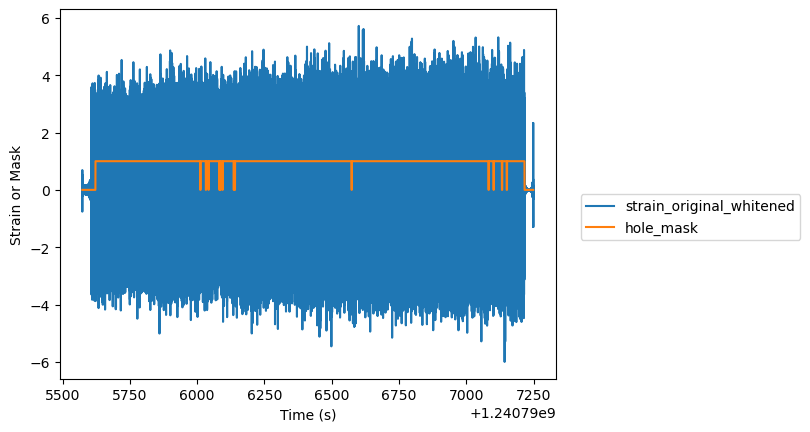

In [7]:
plt.plot(times, original_strain_whitened, label='strain_original_whitened')
plt.plot(times, hole_mask, label='hole_mask')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0.);
plt.xlabel('Time (s)')
plt.ylabel('Strain or Mask');

In [8]:
import matplotlib.ticker as ticker

fname = 'H-H1_GWOSC_O3a_4KHZ_R1-1240793088-4096.hdf5'
t0 = 1240793088.0 # GPS time used for indexing the strain data file
tmin=2550; tmax=4100; # Relative tmin and tmax to t0 (used for making the specgrams)

# This function is used to make spectrograms
def make_specgram(strain):
    fig, ax = plt.subplots(figsize=(10,3))
    rflag = False

    fs = int(np.round(1/dt))
    nfft = fs
    minind = 0
    maxind = len(strain)

    if tmin is not None:
        minind = np.searchsorted(times, tmin + t0)
    if tmax is not None:
        maxind = np.searchsorted(times, tmax + t0)

    vmin = 0
    vmax = 25 / fs

    ax.specgram(
        strain[minind:maxind], NFFT=nfft, Fs=fs, vmin=vmin, vmax=vmax,
        scale='linear')

    deltat = t0 - times[minind]

    def format_data(t, pos):
        return '{:.5g}'.format(t - deltat)

    formatter = ticker.FuncFormatter(format_data)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel(f"Time (s) - {t0}", fontsize=14)
    ax.set_ylabel("Frequency (Hz)", fontsize=14)
    ax.set_title(
        os.path.splitext(os.path.basename(fname))[0],
        fontsize=14, fontweight="bold");

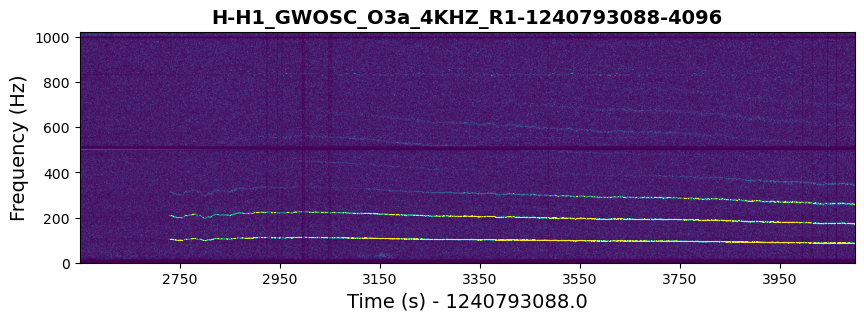

In [9]:
make_specgram(original_strain_whitened)

In [10]:
import scipy.stats as stats
import scipy.signal as signal

def median_bias(n):
    """
    Returns the bias of the median of a set of periodograms relative to
    the mean.
    See arXiv:gr-qc/0509116 Appendix B for details.
    Parameters
    ----------
    n : int
        Numbers of periodograms being averaged.
    Returns
    -------
    bias : float
        Calculated bias.
    """
    ii_2 = 2 * np.arange(1., (n-1) // 2 + 1)
    return 1 + np.sum(1. / (ii_2 + 1) - 1. / ii_2)

In [11]:
def band_eraser(
        strain, strain_wt, dt, notch_pars=None, hole_mask=None):
    """
    Detects bandlimited excess power transients and removes them
    :param strain: Raw strain data, modifies in place 
                        (bands with high-power cells will be removed)
    :param strain_wt: Modifies in place
    :param hole_mask: Boolean mask with zeros at holes in unwhitened data
    :param dt: Time interval between successive elements of data (s)
    :param notch_pars: Parameters for notching loud lines from the strain
    :return:
        1. strain_down: (unwhitened) strain with excess power bands removed 
        2. mask_stft: Mask with excess power bands removed
    """
    T = 2
    chunk_size = 32
    LINE_TRACKING_DF = 2
    
    # In process
    len_data = len(strain_wt)
    len_cell = int(T / dt / 2)
    
    # if the data is not in exact multiples of cell size, append the data on the left
    if (len_data%len_cell) > 0:
        strain_wt = np.append(np.zeros(
                                len_cell - (len_data%len_cell)), strain_wt)
        strain_down_expanded = np.append(np.zeros(
                                len_cell - (len_data%len_cell)), strain)
    else:
        strain_down_expanded = strain.copy()
    
    f_stft, t_stft, strain_stft = signal.stft(strain_wt, nperseg=T/dt,
                                          noverlap=(T/dt)//2, fs=1/dt)
    
    # Calculate indices of freq bins of bands
    f_array = np.arange(16, 512, LINE_TRACKING_DF)
    ind_min = np.zeros_like(f_array); ind_max = np.zeros_like(f_array);
    for i in range(len(f_array)):
        f_max = f_array[i] + LINE_TRACKING_DF
        ind_min[i] = np.searchsorted(f_stft, f_array[i])
        ind_max[i] = np.searchsorted(f_stft, f_max)

        
    survival_scale = 7.824 # = stats.chi2.isf(0.02,2), 0.02 = prob, 2 = d.o.f
    mask_stft = np.ones_like(strain_stft, dtype=bool)

    # Finding which of the stft elements overlap with holes
    stft_overlap_hole = np.ones(len(t_stft), dtype=bool)
    for i in range(len(t_stft)-1):
        # only register if the hole is > 0.01 s
        if np.sum(~hole_mask[int(t_stft[i]/dt):
         int(t_stft[i+1]/dt)]) > 0.01/dt:
            stft_overlap_hole[i:i+2] = False # Flag the two bins which contain the hole
            
    for chunk in range(0, len(t_stft)-chunk_size, 1):
    
        # STFT of strain for the time chunk and remove cells which overlap with holes
        strain_stft_chunk = (strain_stft.T[chunk:chunk+chunk_size]
                                [stft_overlap_hole[chunk:chunk+chunk_size]]).T
                            
        # Calculating the median over a time chunk
        sigmaSQ = np.median(np.abs(strain_stft_chunk)**2) \
                        / median_bias(np.prod(strain_stft_chunk.shape)) / 2
                        
        poisson_lambda = 0.02 * (4 * len(strain_stft_chunk[0]))
        poisson_threshold = stats.poisson.isf(
                            0.1 / (1/dt * 4096), poisson_lambda)
        # rate in Gaussian noise should be 1 per 10 files
        
        for i in range(len(f_array)):
            band = strain_stft_chunk[ind_min[i]:ind_max[i]]
            bad_inds = (np.abs(band)**2) > sigmaSQ * survival_scale
            # flag the lines in mask_stft
            if np.sum(bad_inds) > poisson_threshold:
                mask_stft[ind_min[i]-2:ind_max[i]+2,
                          chunk-chunk_size//4:chunk+chunk_size+chunk_size//4] = 0
                # removing some extra data on the left and right to be conservative
                        
    # Notching the unwhitened strain before using mask_stft
    # to prevent artifacts
    for sos_notch, irl_notch in notch_pars:
        strain_down_expanded = signal.sosfiltfilt(
            sos_notch, strain_down_expanded, padlen=irl_notch)
    
    _, _, strain_stft = signal.stft(strain_down_expanded, nperseg=T/dt,
                                          noverlap=(T/dt)//2, fs=1/dt)
    strain_down_expanded = signal.istft(mask_stft * strain_stft, fs=1/dt,
                            noverlap=(T/dt)//2)[1]
    
    return strain_down_expanded[-len_data:], mask_stft

In [12]:
band_erased_strain, mask_stft = band_eraser(
        original_strain, original_strain_whitened, dt, hole_mask=hole_mask,
        notch_pars=notch_pars)

# band_erased_strain is the cleaned un-whitened strain data

/Users/jayw/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jayw/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


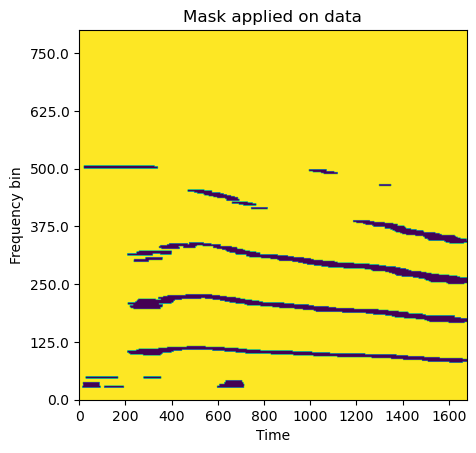

In [13]:
# plt.figure(figsize=(20, 2))
plt.imshow(mask_stft, origin='lower')
plt.xlabel('Time'); plt.ylabel('Frequency bin');
plt.title('Mask applied on data')
# Get current y-axis tick labels and divide them by 2
current_yticks = plt.yticks()[0]
new_ytick_labels = current_yticks / 2

# Set new y-axis tick labels
plt.yticks(current_yticks, labels=new_ytick_labels);
plt.ylim(bottom=0,top=1600);

In [14]:
# The functions in this cell are used just to whiten the data
# from band_erased_strain (these snippets were taken from the IAS pipeline)

support_wt = 19524
fftsize = 262144
wt_filter_fd_fft = np.fft.rfft(np.roll(wt_filter_td, support_wt - 1))
norm_wt = (2. * dt)**0.5

def gen_whitened_strain(strain_down, wt_filter_fd_fft, 
    fftsize, support_wt, norm_wt,valid_mask=None, edgefilling=True, edgesafety=1, 
    notch_wt_filter=False, notch_pars=None,
    **varying_lines_kwargs):
    """
    Whiten and notch, modify strain_wt_down in place, and perhaps identify 
    varying lines in mask_freqs
    :param strain_down: Raw strain data
    :param wt_filter_fd_fft: FFT of wt_filter in TD
    :param valid_mask:
        Boolean mask with zeros where we cannot trust whitened data
    :param support_wt: Support of filter (TD filter has 2 * support - 1 nonzero coeffs)
    :param norm_wt: Normalization factor for whitening: (1 / fmax_psd = 2 * dt)** 0.5
    :param detect_varying_lines: Identify varying lines
    :param edgefilling:  Flag to fill holes at the edges
    :param edgesafety:
        Safety margin at the edge where we cannot trust the nature of the
        whitened data (we haven't applied this to the mask when we get here)
    :param notch_wt_filter:
        Flag to apply notches to the whitening filter as well, setting it to
        True avoids biasing the SNR, but creates artifacts at low frequencies
        (safe to use False as well, since we have PSD drift downstream)
    :param notch_pars: Parameters for applying the notch_wt_filter
    :return:
        1. strain_wt_down
    """
    # Whiten the data with the previously computed whitening filter
    chunked_strain_f = chunkedfft(
        strain_down, fftsize, 2 * support_wt - 1, padmode='center')
    strain_wt_down = norm_wt * overlap_save(
        chunked_strain_f, wt_filter_fd_fft,
        fftsize, 2 * support_wt - 1)[:len(strain_down)]
    
    return strain_wt_down

def overlap_save(chunked_data_f, window_f, fftsize, wl):
    """
    Convolution with the overlap-save method. Look at the modes in chunkedfft
    to understand what transients are captured at the edges
    Coordinates assumed dimensionless, as in DFT
    Note: Overlap-save is only justified when the window is strictly compact
    and contained within wl
    :param chunked_data_f: n_chunk x nrfft(fftsize) array of rFFTs of data chunks
    :param window_f: Complex array of length nrfft(fftsize) RFFT of {window with
                     support within wl, padded to fftsize in the time domain}
    :param fftsize: Size of FFT for each sub-chunk
    :param wl: Length of window (time domain)
    :return: Array of length nchunk x chunksize with convolved data
    """
    # IRFFT along the last axis by default
    fft_in = np.zeros(chunked_data_f.shape, dtype=np.complex128)
    fft_in[:] = chunked_data_f * window_f
    conv = np.fft.irfft(fft_in, n=fftsize)

    # Discard transients and return contiguous output
    chunksize = fftsize - wl + 1
    if conv.ndim == 1:
        return conv[wl - 1:fftsize]
    else:
        return conv[:, wl - 1:fftsize].reshape(len(conv) * chunksize)
    
def chunkedfft(data, fftsize, wl, padmode='left', wraparound=True):
    """
    Returns FFTs of chunks of data for overlap-save. Coordinates assumed
    dimensionless, as in DFT
    :param data: Array with the input data (time domain)
    :param fftsize: Size of FFT for each sub-chunk
    :param wl: Length of window (time domain)
    :param padmode:
        How to pad the data (useful for various choices of window weights and
        time conventions)
    :param wraparound:
        Flag indicating whether to copy data into the padded part to mimic a
        full FFT
    :return: n_chunk x nrfft(fftsize) array of rFFTs of chunks
    """
    # Size of chunk
    chunksize = fftsize - wl + 1

    if padmode == 'left':
        # The first entry is when the right-edge of the filter touches the
        # left edge of the data
        # Captures the starting transient, but not the ending one
        leftpad = wl - 1
    elif padmode == 'center':
        # The first entry is when the filter center touches the left edge
        # of the data
        # Captures half of the starting and ending transients
        # Reproduces the 'same' mode of scipy fftconvolve if wraparound = False
        leftpad = wl // 2
    else:
        # The first entry is when the left-edge of the filter touches the
        # left edge of the data
        # Captures the ending transient but not the starting one
        leftpad = 0
    rightpad = wl - 1 - leftpad

    # Number of chunks (note that >= 2)
    nchunk = int(np.ceil(len(data) / chunksize))
    paddeddata = np.zeros(wl - 1 + chunksize * nchunk)

    # Left and right-pad as needed
    paddeddata[leftpad:leftpad + len(data)] = data

    if wraparound:
        if leftpad > 0:
            # Add right data to left for wrapping around to mimic an fft
            paddeddata[:leftpad] = data[-leftpad:]
        # Add left data to right for wrapping around to mimic fft
        paddeddata[leftpad + len(data):leftpad + len(data) + rightpad] = \
            data[:rightpad]

    # Structure to hold rFFT of data
    rfft_vec = np.zeros((nchunk, fftsize // 2 + 1), dtype=np.complex128)
    for chid in range(nchunk):
        rfft_vec[chid] = np.fft.rfft(
            paddeddata[chid * chunksize:chid * chunksize + fftsize])

    return rfft_vec

In [15]:
band_erased_strain_wt = gen_whitened_strain(
                    band_erased_strain, wt_filter_fd_fft, 
                    fftsize, support_wt, norm_wt, edgefilling=False, 
                    edgesafety=False, notch_wt_filter=True, 
                    notch_pars=None)

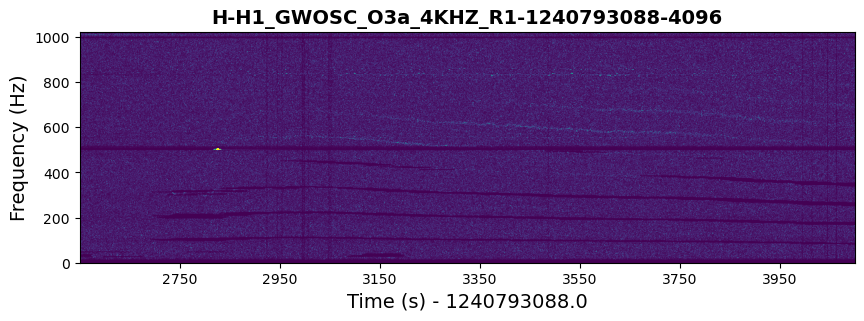

In [16]:
make_specgram(band_erased_strain_wt)